# Rescheduling mit Tardiness (Summe)
> Planunghorizont Tag 0: 2 Tage
> Rescheduling des Tages 1

In [1]:
# Datenzugriff
from configs.config import get_path

# Utils
import src.utils.presenter as show
from src.utils.production_process import convert
from src.utils.production_process import initialize as init
from src.utils.analize import check_constrains as check

from src.utils.production_process import time_determination as term
from src.utils.production_process import gen_deadline as gen_deadline
from src.utils.production_process import filter as process_filter

# Solver Model
from src.models.cp import lateness_scheduling as cp_late_schedule
from src.models.cp import lateness_rescheduling as cp_late_reschedule
import src.models.heuristics.fcfs as fcfs


# Simulation
from src.simulation.ProductionDaySimulation import ProductionDaySimulation


# Extern
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 21)

In [2]:
max_time = 60 * 10 # 10 min

In [3]:
basic_data_path = get_path("data", "basic")
day_count = 1

df_instance = pd.read_csv(basic_data_path / "instance.csv")
df_jssp, df_job_arrivals = init.create_production_orders_for_shifts(df_template=df_instance, shift_count=day_count,
                                                                 u_b_mmax= 0.94, shift_length=1440, shuffle=True,
                                                                 job_seed=40, arrival_seed=80)

df_job_times = gen_deadline.get_times_df(df_jssp, df_job_arrivals, fcfs.schedule_with_arrivals, target_service=1.0)
df_job_times


Schedule-Informationen:
  Makespan: 2400


,Job,Production_Plan_ID,Arrival,Deadline
0,0,0,49,848.0
1,1,1,130,1162.0
2,2,2,151,1300.0
3,3,3,226,1551.0
4,4,4,386,1181.0
5,5,5,464,1467.0
6,6,6,480,1322.0
7,7,7,506,1596.0
8,8,8,526,1734.0
9,9,9,535,1627.0


In [4]:
df_job_times['Job'] = df_job_times['Job'].astype(str)
df_jssp['Job'] = df_jssp['Job'].astype(str)

In [5]:
# Rundung für CP 
df_job_times["Arrival"] = np.floor(df_job_times["Arrival"]).astype(int)
df_job_times["Deadline"] = np.ceil(df_job_times["Deadline"]).astype(int)
df_job_times

,Job,Production_Plan_ID,Arrival,Deadline
0,0,0,49,848
1,1,1,130,1162
2,2,2,151,1300
3,3,3,226,1551
4,4,4,386,1181
5,5,5,464,1467
6,6,6,480,1322
7,7,7,506,1596
8,8,8,526,1734
9,9,9,535,1627


In [6]:
# b) Bestimmung der "Ready Time"
df_job_times['Ready Time'] = ((df_job_times['Arrival'] // 1440) + 1) * 1440

# c) Processing Time
processing_time = df_jssp.groupby('Job')['Processing Time'].sum()
df_job_times = pd.merge(df_job_times, processing_time, on='Job')

# d) Bestimmung des Slacks
df_job_times['Slack'] = df_job_times['Deadline'] - (df_job_times['Ready Time'] + df_job_times['Processing Time'])

# e) Anpassung der Deadlines
min_slack = df_job_times['Slack'].min()

if min_slack < 0:
    df_job_times["Deadline"] = df_job_times["Deadline"] + abs(min_slack) + 120
df_job_times

# f) erneute Bestimmung des Slacks
df_job_times['Slack'] = df_job_times['Deadline'] - (df_job_times['Ready Time'] + df_job_times['Processing Time'])
df_job_times 

,Job,Production_Plan_ID,Arrival,Deadline,Ready Time,Processing Time,Slack
0,0,0,49,1955,1440,395,120
1,1,1,130,2269,1440,510,319
2,2,2,151,2407,1440,568,399
3,3,3,226,2658,1440,655,563
4,4,4,386,2288,1440,393,455
5,5,5,464,2574,1440,496,638
6,6,6,480,2429,1440,416,573
7,7,7,506,2703,1440,539,724
8,8,8,526,2841,1440,597,804
9,9,9,535,2734,1440,540,754


In [7]:
day_length = 1440

## I) Tag 1

In [8]:
day_numb = 1

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [9]:
def filter_ops_and_jobs_by_ready_time(df_job_times: pd.DataFrame, df_jssp: pd.DataFrame, 
                              ready_time_col = "Ready Time", ready_time: int = 0) -> tuple[pd.DataFrame, pd.DataFrame]:

    # Jobs zeitlich filtern
    time_filter = df_job_times[ready_time_col] == ready_time
    df_job_times_filtered = df_job_times[time_filter].copy()

    # Operationen nach (gefilterten) Jobs filtern
    jobs = df_job_times_filtered["Job"]
    df_jssp_filtered = df_jssp[df_jssp["Job"].isin(jobs)].copy()
    return df_job_times_filtered, df_jssp_filtered

In [10]:
df_job_times_curr, df_jssp_curr = filter_ops_and_jobs_by_ready_time(df_job_times, df_jssp, ready_time = day_start)
df_job_times_curr

,Job,Production_Plan_ID,Arrival,Deadline,Ready Time,Processing Time,Slack
0,0,0,49,1955,1440,395,120
1,1,1,130,2269,1440,510,319
2,2,2,151,2407,1440,568,399
3,3,3,226,2658,1440,655,563
4,4,4,386,2288,1440,393,455
5,5,5,464,2574,1440,496,638
6,6,6,480,2429,1440,416,573
7,7,7,506,2703,1440,539,724
8,8,8,526,2841,1440,597,804
9,9,9,535,2734,1440,540,754


### A) Scheduling für Tag 1

In [11]:
# Scheduling
df_schedule = cp_late_schedule.solve_jssp_sum(df_jssp, df_job_times, schedule_start = day_start,
                                         msg=False, timeLimit=max_time)
df_schedule 


Solver-Status           : OPTIMAL
Summe Absolute Lateness : 33.0
Best Objective Bound    : 33.0
Laufzeit                : 0.10 Sekunden


,Job,Production_Plan_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,0,0,0,M00,49,1955,1440,29,1469,-486,0,486
1,2,2,0,M01,151,2407,1440,91,1531,-876,0,876
2,4,4,0,M02,386,2288,1440,14,1454,-834,0,834
3,5,5,0,M02,464,2574,1454,84,1538,-1036,0,1036
4,1,1,0,M00,130,2269,1469,43,1512,-757,0,757
...,...,...,...,...,...,...,...,...,...,...,...,...
195,17,3,7,M03,1285,3717,3339,98,3437,-280,0,280
196,16,1,9,M08,1254,3393,3363,30,3393,0,0,0
197,17,3,8,M09,1285,3717,3437,22,3459,-258,0,258
198,18,5,9,M07,1397,3507,3482,25,3507,0,0,0


In [12]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Lateness'))

label
<-180           0
-180 - -120     0
-120 - -60      0
-60 - 0         0
0              19
0 - 60          1
60 - 120        0
120 - 180       0
>180            0
Name: count, dtype: int64


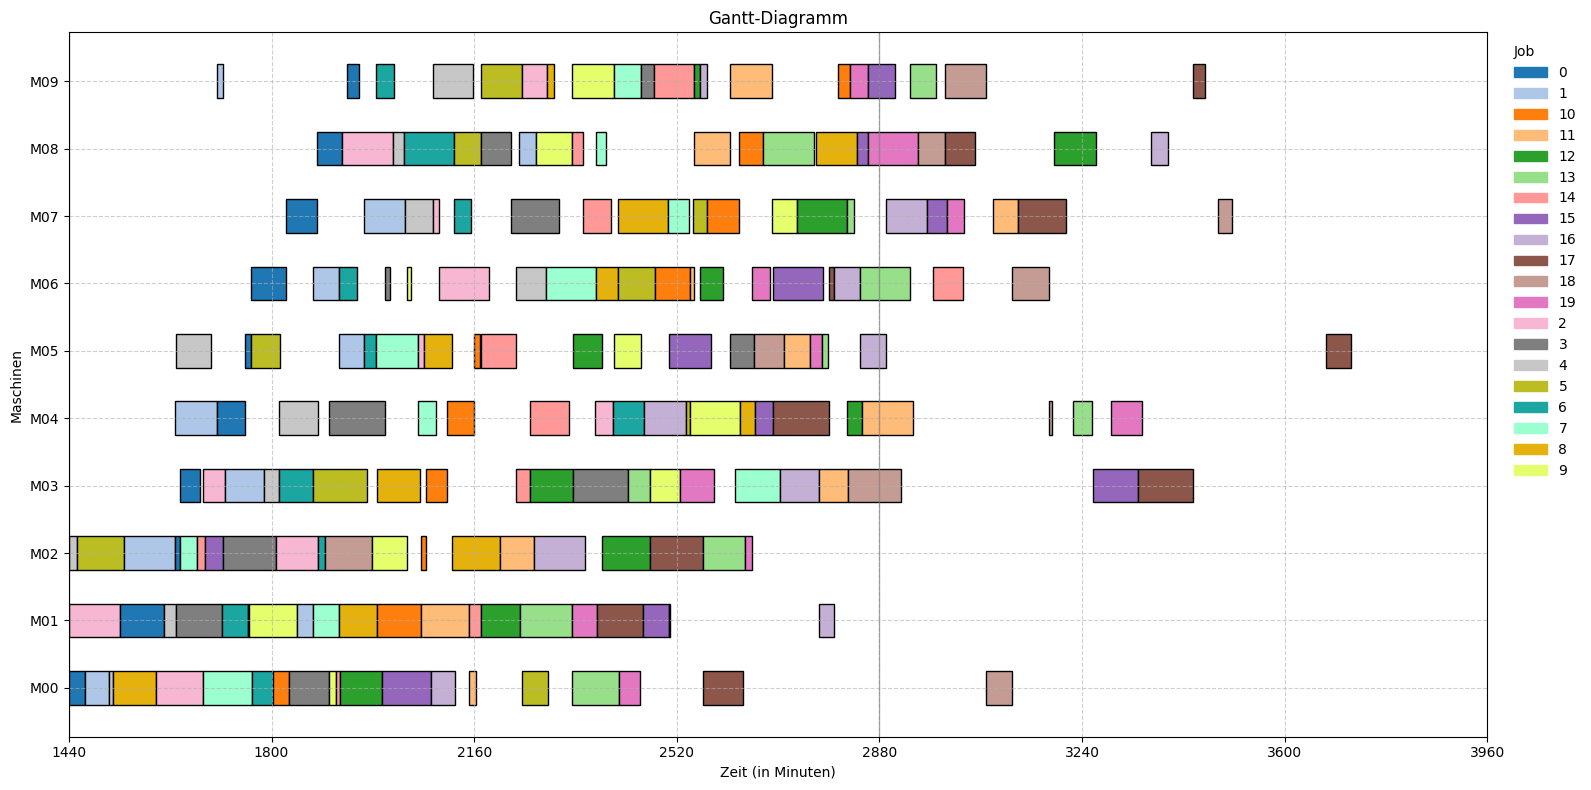

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [13]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

### B) Simulation

In [14]:
simulation = ProductionDaySimulation(df_schedule, vc=0.35)
df_execution = simulation.run(start_time = day_start, end_time=day_end)

[24:00:00] Job 0 started on M00
[24:00:00] Job 2 started on M01
[24:00:00] Job 4 started on M02
[24:19:03] Job 4 finished on M02 (after 19 minutes 04 seconds)
[24:19:03] Job 5 started on M02
[24:33:10] Job 0 finished on M00 (after 33 minutes 11 seconds)
[24:33:10] Job 1 started on M00
[25:21:46] Job 1 finished on M00 (after 48 minutes 36 seconds)
[25:21:46] Job 4 started on M00
[25:27:15] Job 2 finished on M01 (after 87 minutes 15 seconds)
[25:31:00] Job 0 started on M01
[25:33:43] Job 4 finished on M00 (after 11 minutes 56 seconds)
[25:33:43] Job 8 started on M00
[26:26:37] Job 5 finished on M02 (after 127 minutes 34 seconds)
[26:26:37] Job 1 started on M02
[26:47:39] Job 8 finished on M00 (after 73 minutes 56 seconds)
[26:47:39] Job 2 started on M00
[27:19:02] Job 0 finished on M01 (after 108 minutes 02 seconds)
[27:19:02] Job 4 started on M01
[27:28:36] Job 1 finished on M02 (after 61 minutes 59 seconds)
[27:28:36] Job 7 started on M02
[27:28:36] Job 1 started on M04
[27:55:22] Job 

In [15]:
df_plan_undone = process_filter.get_unexecuted_operations(df_schedule, df_execution)
df_plan_undone 

,Job,Production_Plan_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,11,9,5,M09,928,3127,2614,76,2690,-437,0,437
1,16,1,4,M03,1254,3393,2703,69,2772,-621,0,621
2,11,9,6,M05,928,3127,2710,47,2757,-370,0,370
3,12,8,7,M07,950,3265,2734,89,2823,-442,0,442
4,11,9,7,M03,928,3127,2772,52,2824,-303,0,303
...,...,...,...,...,...,...,...,...,...,...,...,...
35,17,3,7,M03,1285,3717,3339,98,3437,-280,0,280
36,16,1,9,M08,1254,3393,3363,30,3393,0,0,0
37,17,3,8,M09,1285,3717,3437,22,3459,-258,0,258
38,18,5,9,M07,1397,3507,3482,25,3507,0,0,0


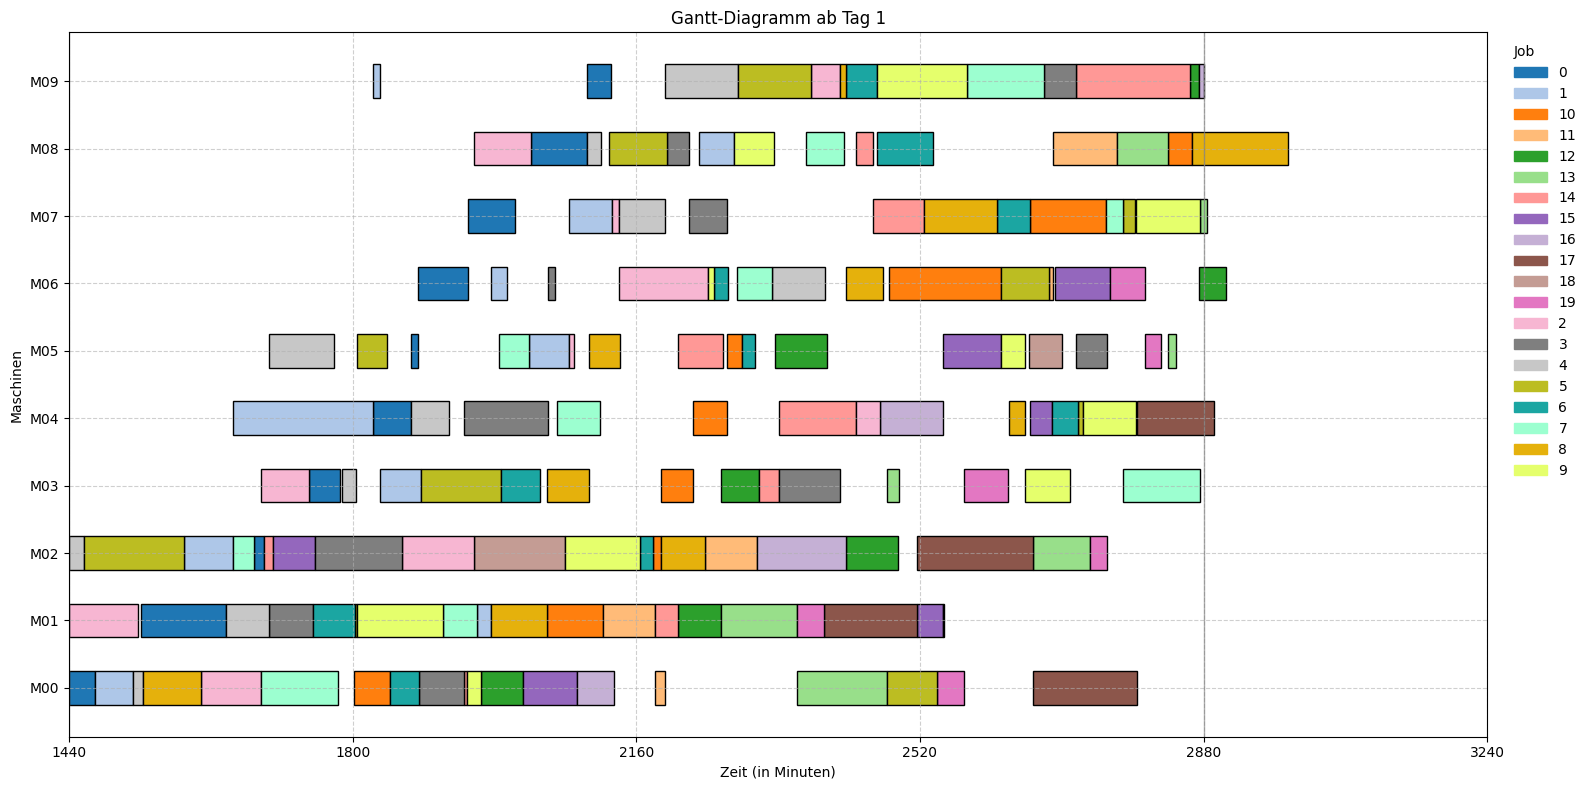

In [16]:
if not df_execution.empty:
    show.plot_gantt(df_execution, perspective="Machine", title=f"Gantt-Diagramm ab Tag {day_numb}")
else:
    print(f"Nothing executed on day {day_numb}")

## II) Tag 2
> vereinfacht, ohne neu Aufträge (nur der Rest)

In [17]:
day_numb = 2

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


#### a) Filtern nach der aktuellen "Ready Time"

In [18]:
df_job_times_curr, df_jssp_curr = filter_ops_and_jobs_by_ready_time(df_job_times, df_jssp, ready_time = day_start)
df_job_times_curr

,Job,Production_Plan_ID,Arrival,Deadline,Ready Time,Processing Time,Slack


#### b) Unerledigte Operationen

In [19]:
df_plan_undone

,Job,Production_Plan_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,11,9,5,M09,928,3127,2614,76,2690,-437,0,437
1,16,1,4,M03,1254,3393,2703,69,2772,-621,0,621
2,11,9,6,M05,928,3127,2710,47,2757,-370,0,370
3,12,8,7,M07,950,3265,2734,89,2823,-442,0,442
4,11,9,7,M03,928,3127,2772,52,2824,-303,0,303
...,...,...,...,...,...,...,...,...,...,...,...,...
35,17,3,7,M03,1285,3717,3339,98,3437,-280,0,280
36,16,1,9,M08,1254,3393,3363,30,3393,0,0,0
37,17,3,8,M09,1285,3717,3437,22,3459,-258,0,258
38,18,5,9,M07,1397,3507,3482,25,3507,0,0,0


In [20]:
# Sicherstellen, dass beide DataFrames die Spalten 'Job' und 'Operation' haben
df_jssp_undone = df_jssp.merge(df_plan_undone[["Job", "Operation"]], on=["Job", "Operation"], how="inner")
df_jssp_undone

,Job,Production_Plan_ID,Operation,Machine,Processing Time
0,10,0,9,M09,21
1,11,9,5,M09,76
2,11,9,6,M05,47
3,11,9,7,M03,52
4,11,9,8,M04,90
...,...,...,...,...,...
35,18,5,9,M07,25
36,19,6,6,M09,32
37,19,6,7,M08,89
38,19,6,8,M07,30


In [21]:
df_job_times_undone = df_job_times[df_job_times["Job"].isin(df_jssp_undone["Job"].unique())]
df_job_times_undone

,Job,Production_Plan_ID,Arrival,Deadline,Ready Time,Processing Time,Slack
10,10,0,922,2828,1440,395,993
11,11,9,928,3127,1440,540,1147
12,12,8,950,3265,1440,597,1228
13,13,2,1001,3257,1440,568,1249
14,14,4,1127,3029,1440,393,1196
15,15,7,1142,3339,1440,539,1360
16,16,1,1254,3393,1440,510,1443
17,17,3,1285,3717,1440,655,1622
18,18,5,1397,3507,1440,496,1571
19,19,6,1398,3347,1440,416,1491


### Zusammenführen

In [22]:
# Operationen
df_jssp_curr_all = pd.concat([df_jssp_curr, df_jssp_undone], ignore_index=True)
df_jssp_curr_all = df_jssp_curr_all.sort_values(by=["Job", "Operation"]).reset_index(drop=True)
df_jssp_curr_all

,Job,Production_Plan_ID,Operation,Machine,Processing Time
0,10,0,9,M09,21
1,11,9,5,M09,76
2,11,9,6,M05,47
3,11,9,7,M03,52
4,11,9,8,M04,90
...,...,...,...,...,...
35,18,5,9,M07,25
36,19,6,6,M09,32
37,19,6,7,M08,89
38,19,6,8,M07,30


In [23]:
df_job_times_curr_all = pd.concat([df_job_times_curr, df_job_times_undone], ignore_index=True)
df_job_times_curr_all = df_job_times_curr_all.drop_duplicates(subset="Job", keep="first").sort_values(by="Job").reset_index(drop=True)
df_job_times_curr_all

,Job,Production_Plan_ID,Arrival,Deadline,Ready Time,Processing Time,Slack
0,10,0,922,2828,1440,395,993
1,11,9,928,3127,1440,540,1147
2,12,8,950,3265,1440,597,1228
3,13,2,1001,3257,1440,568,1249
4,14,4,1127,3029,1440,393,1196
5,15,7,1142,3339,1440,539,1360
6,16,1,1254,3393,1440,510,1443
7,17,3,1285,3717,1440,655,1622
8,18,5,1397,3507,1440,496,1571
9,19,6,1398,3347,1440,416,1491


### A) Rescheduling für Tag 2

In [24]:
# Reduktion der bereits ausgeführten Operationen, die im heutigen Plan hineinlaufen
df_execution_important = df_execution[df_execution["End"] >= day_start]
df_execution_important

,Job,Production_Plan_ID,Operation,Machine,Arrival,Start,Processing Time,End
40,12,8,6,M06,950,2873.56,34.72,2908.28
47,13,2,6,M07,1001,2874.87,9.94,2884.81
66,16,1,3,M09,1254,2873.56,7.39,2880.95
70,17,3,3,M04,1285,2795.09,97.79,2892.88
149,8,8,9,M08,526,2865.82,120.89,2986.71


In [25]:
df_reschedule = cp_late_reschedule.solve_jssp_by_tardiness_and_earliness_with_fixed_ops(df_jssp_curr_all, df_job_times_curr_all, 
                                                                                 df_execution_important,
                                                                                 w_t = 5,
                                                                                 reschedule_start = day_start, msg=False, 
                                                                                 timeLimit=max_time, gapRel= 0)
df_reschedule


Solver-Status         : OPTIMAL
Objective Value       : 795.00
Best Objective Bound  : 795.00
Laufzeit              : 0.01 Sekunden


,Job,Production_Plan_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,18,5,3,M03,1397,3507,2880,95,2975,-532,0,532
1,10,0,9,M09,922,2828,2881,21,2902,74,74,0
2,11,9,5,M09,928,3127,2902,76,2978,-149,0,149
3,12,8,7,M07,950,3265,2909,89,2998,-267,0,267
4,17,3,4,M06,1285,3717,2909,9,2918,-799,0,799
...,...,...,...,...,...,...,...,...,...,...,...,...
35,16,1,9,M08,1254,3393,3363,30,3393,0,0,0
36,17,3,7,M03,1285,3717,3423,98,3521,-196,0,196
37,18,5,9,M07,1397,3507,3482,25,3507,0,0,0
38,17,3,8,M09,1285,3717,3521,22,3543,-174,0,174


In [27]:
last_ops = df_reschedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Lateness'))

label
<-180          0
-180 - -120    0
-120 - -60     0
-60 - 0        0
0              8
0 - 60         0
60 - 120       2
120 - 180      0
>180           0
Name: count, dtype: int64


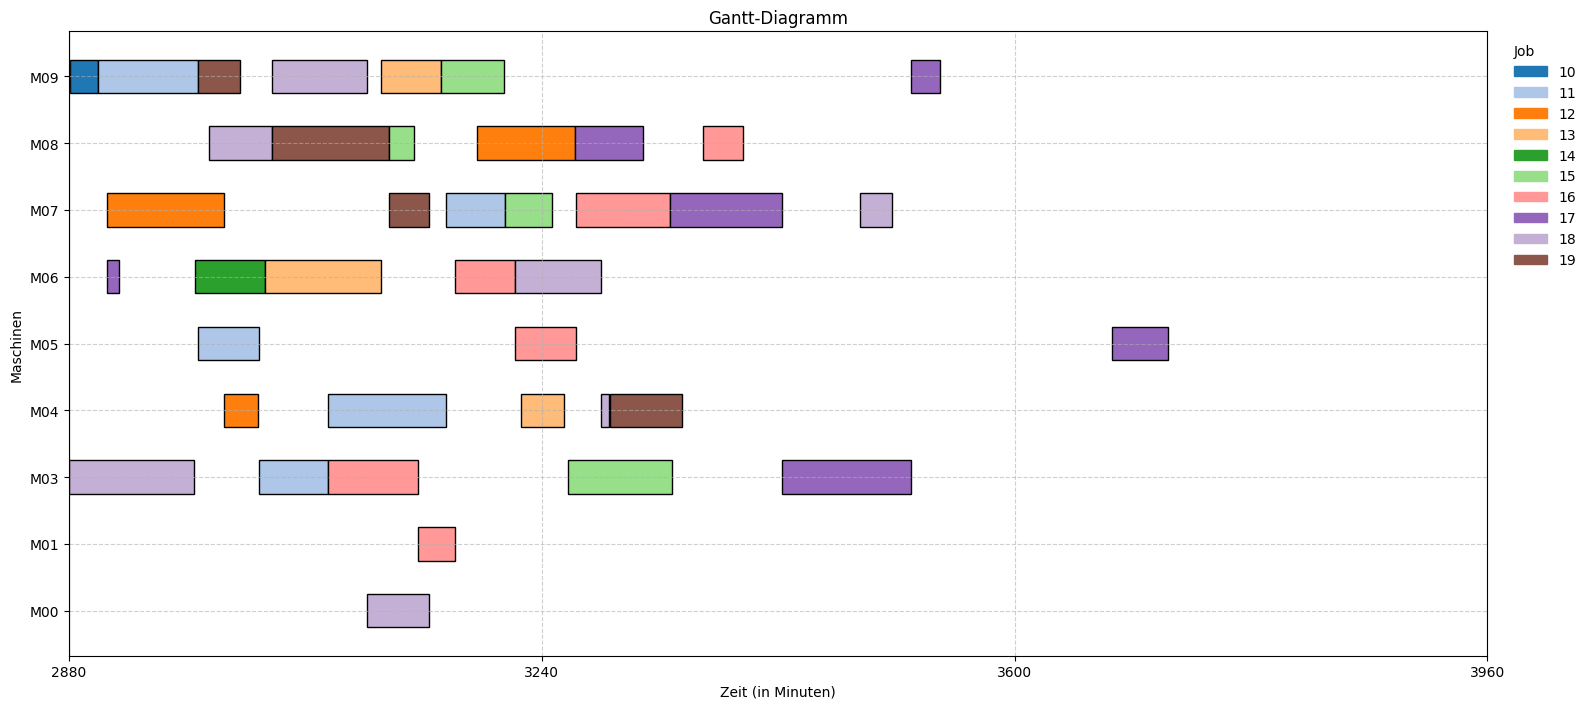

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [28]:
show.plot_gantt(df_reschedule, perspective="Machine")
check.is_machine_conflict_free(df_reschedule)
check.is_operation_sequence_correct(df_reschedule)
check.is_job_timing_correct(df_reschedule)
check.is_start_correct(df_reschedule)

### Combi aus Simulation und Neuplannung

In [29]:
df_combined = pd.concat([df_execution, df_reschedule], ignore_index=True)
df_combined

,Job,Production_Plan_ID,Operation,Machine,Arrival,Start,Processing Time,End,Deadline,Lateness,Tardiness,Earliness
0,0,0,0,M00,49,1440.00,33.18,1473.18,NaN,NaN,NaN,NaN
1,0,0,1,M01,49,1531.00,108.04,1639.04,NaN,NaN,NaN,NaN
2,0,0,2,M02,49,1675.38,11.92,1687.30,NaN,NaN,NaN,NaN
3,0,0,3,M03,49,1744.28,39.62,1783.90,NaN,NaN,NaN,NaN
4,0,0,4,M04,49,1825.33,49.05,1874.38,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
195,16,1,9,M08,1254,3363.00,30.00,3393.00,3393.0,0.0,0.0,0.0
196,17,3,7,M03,1285,3423.00,98.00,3521.00,3717.0,-196.0,0.0,196.0
197,18,5,9,M07,1397,3482.00,25.00,3507.00,3507.0,0.0,0.0,0.0
198,17,3,8,M09,1285,3521.00,22.00,3543.00,3717.0,-174.0,0.0,174.0


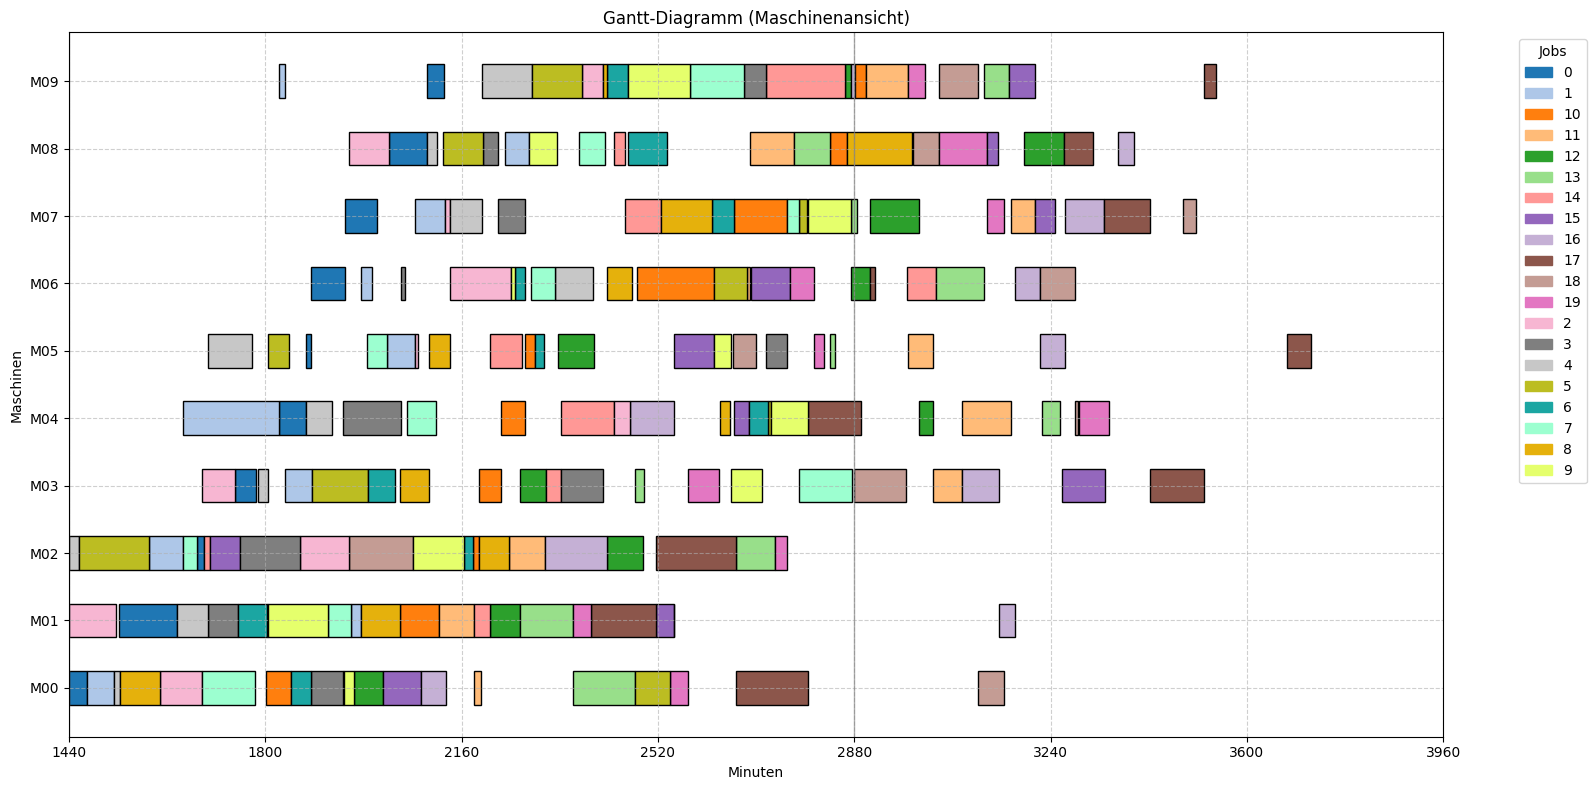

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [30]:
df = df_combined
show.plot_gantt_machines(df)
check.is_machine_conflict_free(df)
check.is_operation_sequence_correct(df)
check.is_job_timing_correct(df)
check.is_start_correct(df)